In [1]:
import dask.dataframe as dd
from nltk.corpus import stopwords
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from dask.diagnostics import ProgressBar
%matplotlib inline
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from src.utils.helpers_news_movies import *
from collections import defaultdict
from scipy.sparse import csr_matrix

import plotly.express as px

# Import code from other files
from src.model import model as m
from src.utils import helpers_temporality_analysis

/Users/antoine/anaconda3/envs/gensim_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load cosine similarity dataframes
cosine_similarity_news_df = pd.read_csv('data/df_news/cosine_similarity_news.csv')
# remove unnamed column 
cosine_similarity_news_df.drop(cosine_similarity_news_df.columns[cosine_similarity_news_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
cosine_similarity_movies_df = pd.read_csv('data/df_movies/cosine_similarity_movies.csv')

print(cosine_similarity_news_df.head())
print(cosine_similarity_movies_df.head())

themes = ['vietnam', 'cold_war', 'irak_war', 'ww2', 'technology', 'economy', 'health', 'gender_equality', 'migration']


    vietnam  cold_war  irak_war       ww2  technology   economy    health  \
0  0.153291  0.047631  0.079034  0.176376   -0.009598 -0.036335  0.018983   
1  0.078121 -0.039955  0.060634  0.018526    0.002312  0.039167  0.011849   
2  0.098636  0.101309  0.081472  0.028555    0.181080  0.131787  0.009973   
3 -0.044569  0.026489  0.078098  0.059428    0.136175  0.144368  0.073137   
4 -0.001666  0.053340  0.017597  0.049338   -0.062218 -0.034126  0.001495   

   gender_equality  migration        id  year  
0         0.044182  -0.069827  13355234  1992  
1        -0.009306   0.025387   4220746  1941  
2         0.103763   0.065460  11058934  1974  
3         0.148868   0.050505  12915396  1989  
4        -0.055145  -0.052538  10134262  1968  
      index   vietnam  cold_war  irak_war       ww2  technology   economy  \
0  23890098  0.089712  0.133718  0.066871  0.066404    0.084017  0.057000   
1  31186339  0.134952  0.065855  0.159707  0.089287    0.031679  0.090338   
2  20663735  0.058

In [3]:
# convert cosine similarity to bool with threshold of 0.3

cosine_similarity_news_df_bool = cosine_similarity_news_df.copy()
cosine_similarity_movies_df_bool = cosine_similarity_movies_df.copy()

for theme in themes:
    cosine_similarity_news_df_bool[theme] = cosine_similarity_news_df_bool[theme].apply(lambda x: 1 if x > 0.1 else 0)
    cosine_similarity_movies_df_bool[theme] = cosine_similarity_movies_df_bool[theme].apply(lambda x: 1 if x > 0.1 else 0)



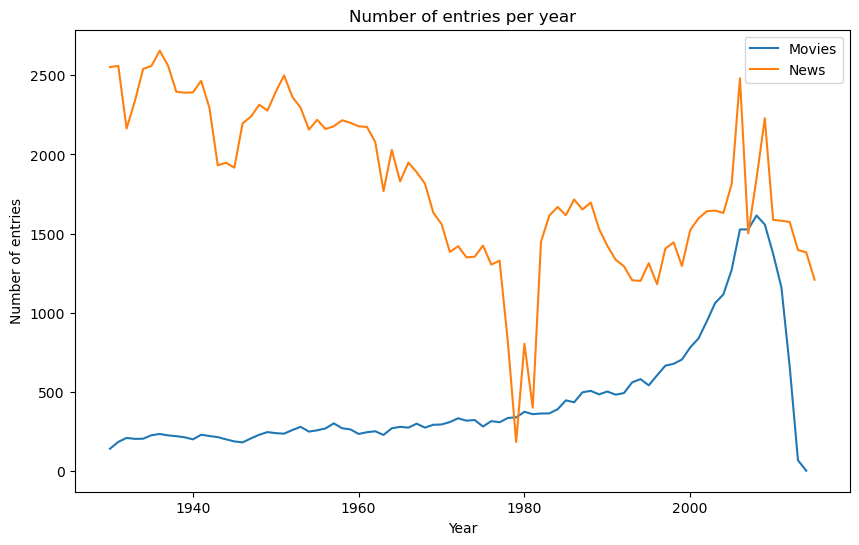

In [4]:
# Number of articles per year
movies_per_year = cosine_similarity_movies_df_bool['year'].value_counts()
news_per_year = cosine_similarity_news_df_bool['year'].value_counts()

# Sort by index
movies_per_year = movies_per_year.sort_index()
news_per_year = news_per_year.sort_index()


# Plot number of movies per year
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, label='Movies')
plt.plot(news_per_year.index, news_per_year.values, label='News')

plt.xlabel('Year')
plt.ylabel('Number of entries')
plt.title('Number of entries per year')
plt.legend()
plt.show()




            index  vietnam  cold_war  irak_war  ww2  technology  economy  \
year                                                                       
1930   2091713455       57        24        56   67          13       42   
1931   2988855349       60        35        57   66          25       48   
1932   3273398521       54        32        60   63          32       70   
1933   3238364224       71        42        54   77          38       52   
1934   3328130955       57        33        51   64          31       55   
...           ...      ...       ...       ...  ...         ...      ...   
2010  37193963007      472       350       618  496         410      398   
2011  35355804336      391       284       514  410         369      327   
2012  21830623616      216       164       292  230         232      195   
2013   2332433405       36        24        33   44          32       29   
2014    145644833        2         1         2    3           1        0   

      healt

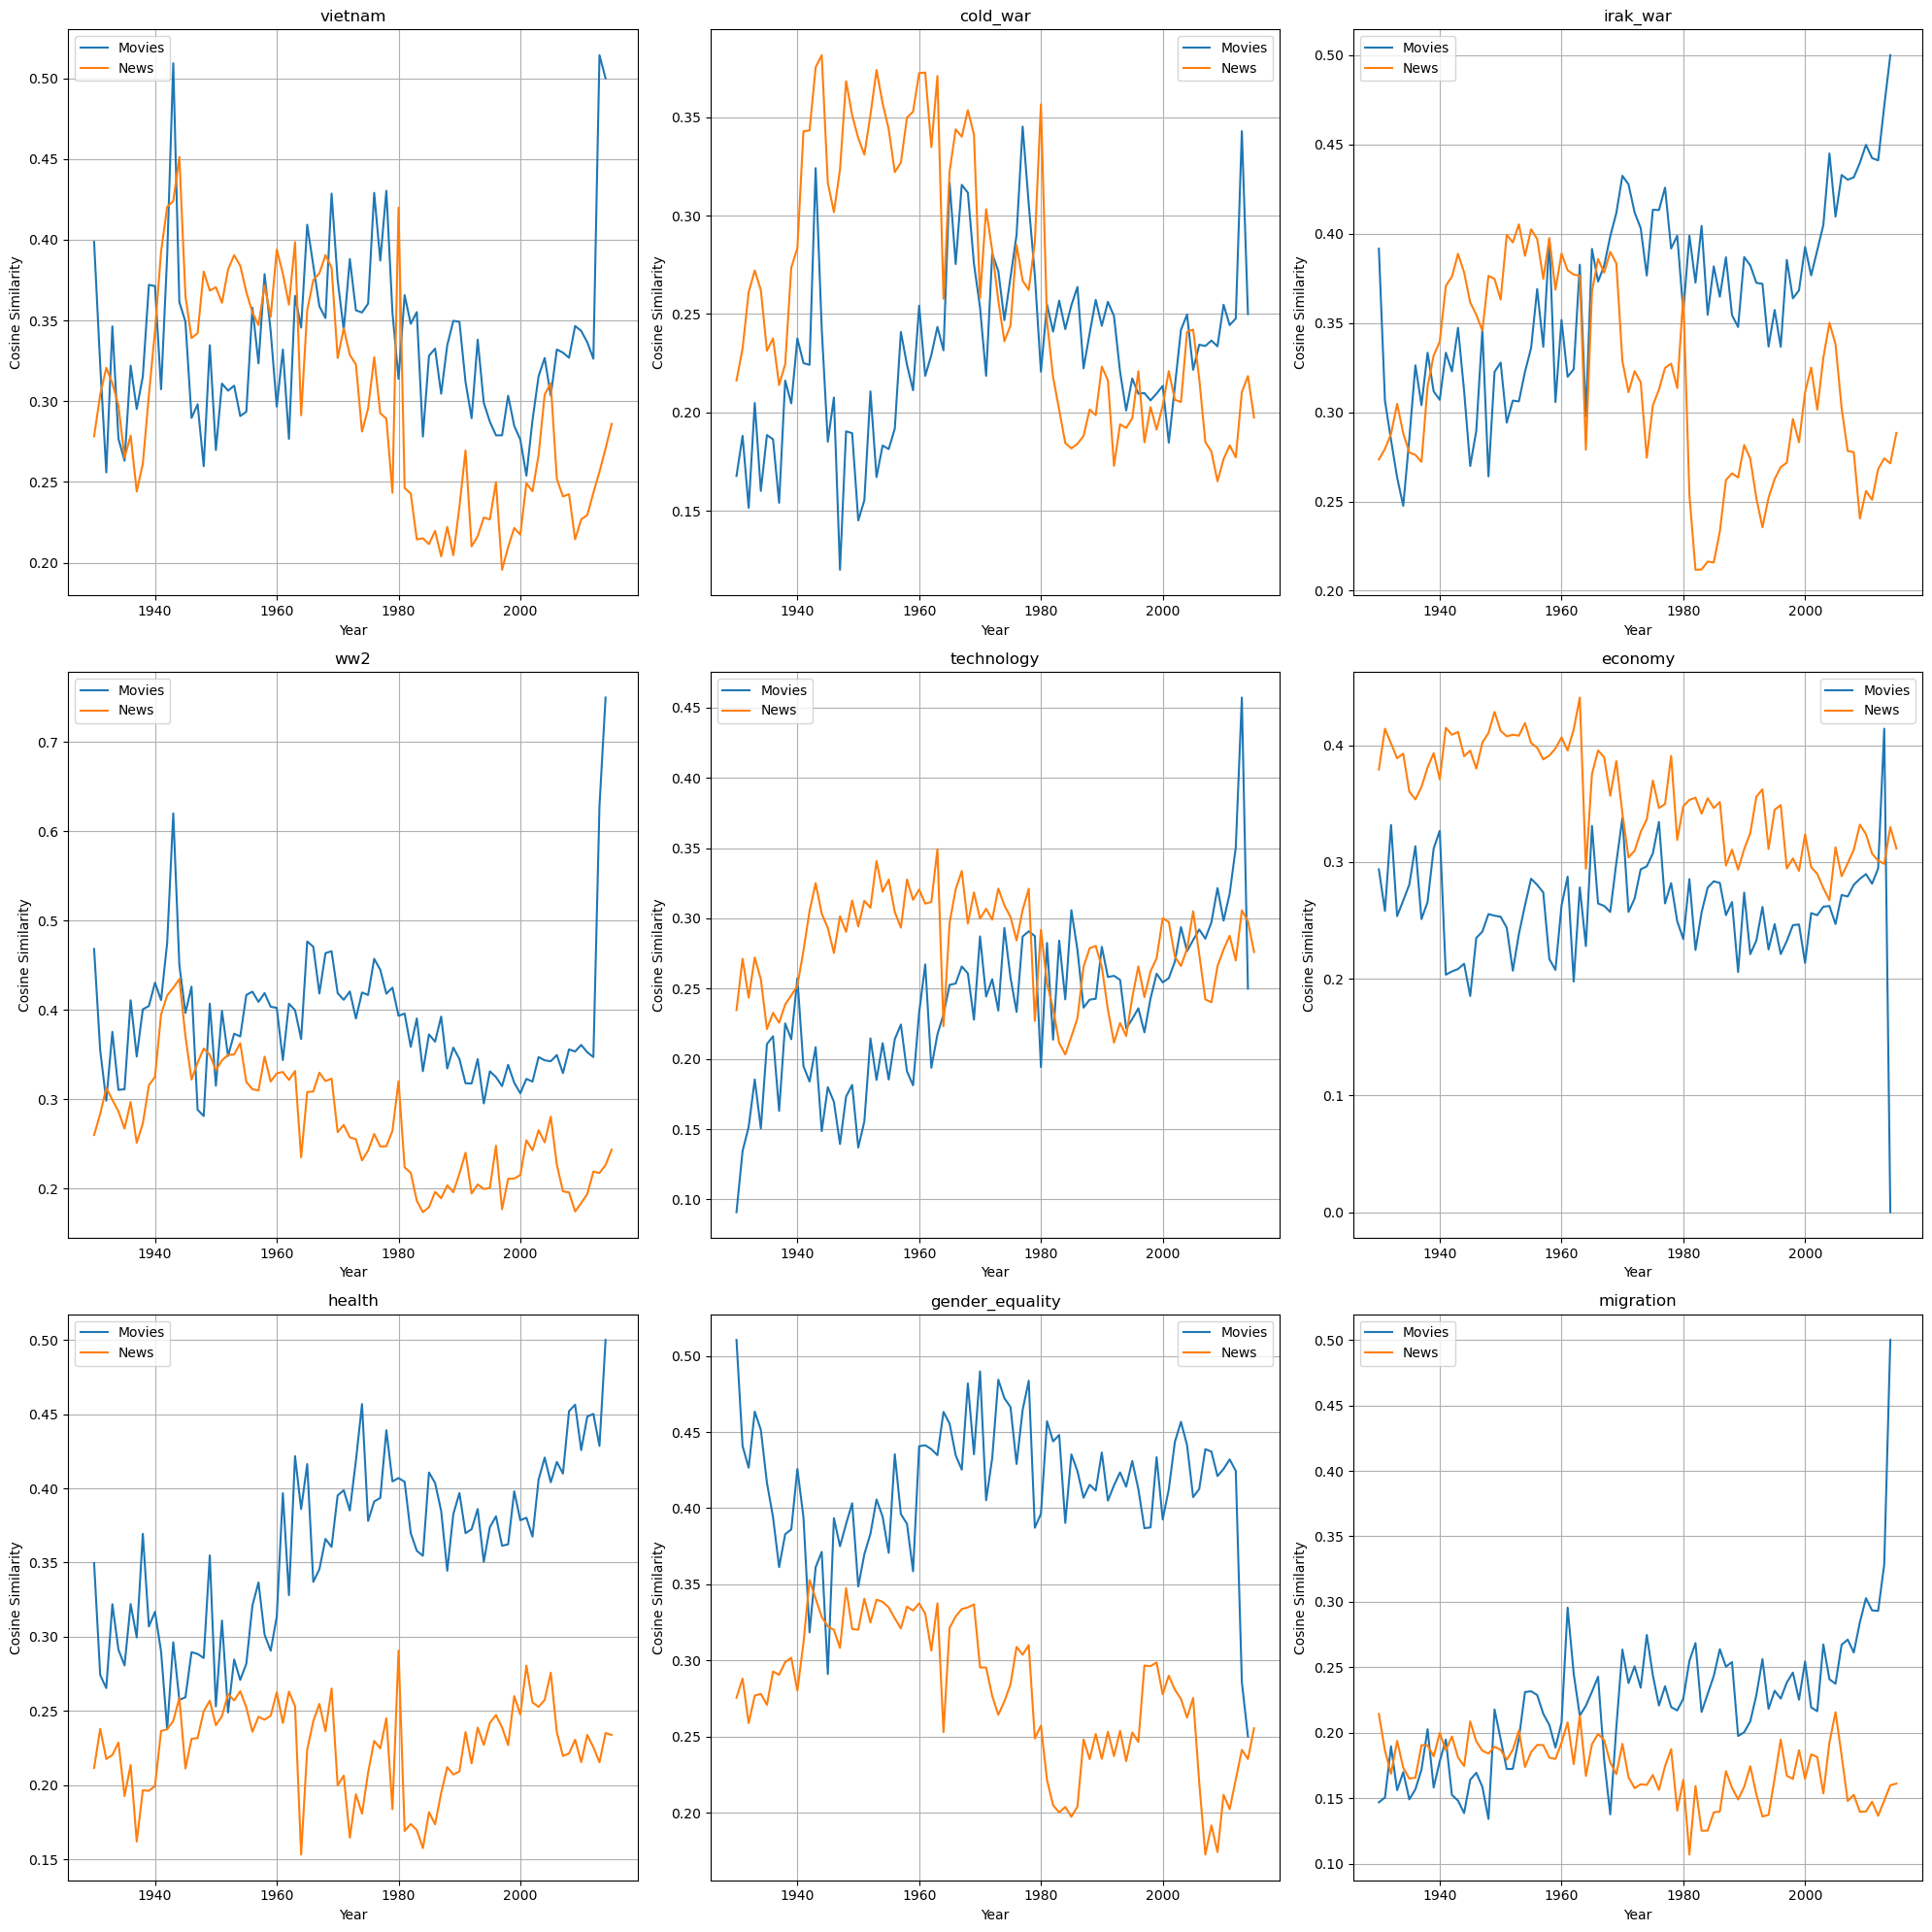

In [5]:
# Plot the cosine similarity for each query over time

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i, column in enumerate(themes):
    row = i // 3
    col = i % 3
    # Sum the boolean values for each year
    grouped_movies = cosine_similarity_movies_df_bool.groupby('year').sum()
    grouped_news = cosine_similarity_news_df_bool.groupby('year').sum()
    print(grouped_movies)

    # Normalize the values by the number of articles in the year
    grouped_movies = grouped_movies.div(movies_per_year, axis=0)
    ax[row, col].plot(grouped_movies.index, grouped_movies[column])

    grouped_news = grouped_news.div(news_per_year, axis=0)
    ax[row, col].plot(grouped_news.index, grouped_news[column])
    ax[row, col].legend(['Movies', 'News'])
    ax[row, col].set_title(column)
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Cosine Similarity')
    ax[row, col].grid()


plt.tight_layout()
plt.show()


vietnam            0.186296
cold_war          -0.052637
irak_war          -0.295833
ww2                0.275007
technology        -0.080003
economy           -0.061142
health            -0.169441
gender_equality   -0.174535
migration         -0.404915
id                      NaN
index                   NaN
dtype: float64


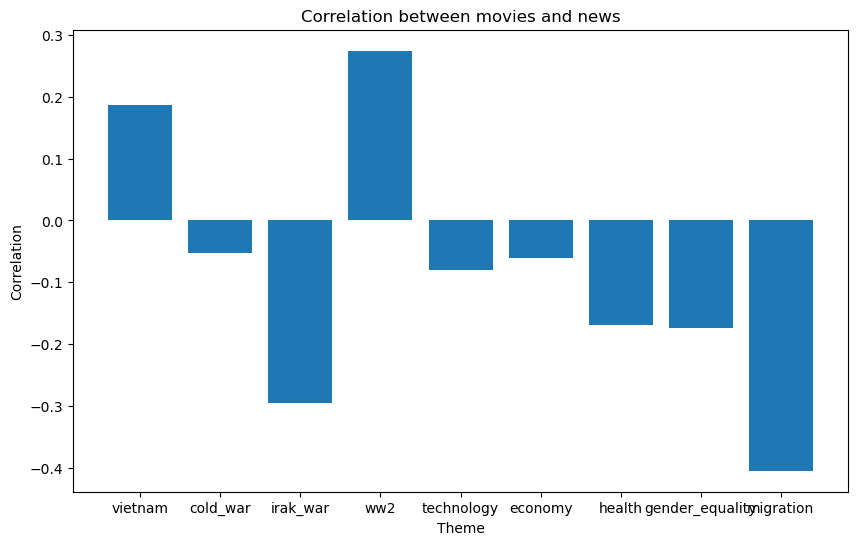

In [6]:
# Compute the corelation between the cosine similarity of movies and news

correlation = grouped_movies.corrwith(grouped_news, axis=0)
print(correlation)

# Plot the correlation
plt.figure(figsize=(10, 6))

plt.bar(correlation.index, correlation.values)
plt.xlabel('Theme')
plt.ylabel('Correlation')
plt.title('Correlation between movies and news')
plt.show()


In [24]:
def plot_movies_and_news_frequency(theme, time_unit='Year'):
    """
    Plot the evolution of the frequency of movies and news per decade or year, normalized by the full datasets.
    Arguments:
        df_movie: DataFrame containing movie data.
        theme: String representing the theme (column name in df_news).
        time_unit: String specifying time unit ('Year' or 'Decade').

    Returns:
        Plotly figure.
    """ 
    TIME_START = 1930
    TIME_END = 2013
    MOVIES_MARKER = px.colors.qualitative.Prism[1]  # Blue
    NEWS_MARKER = px.colors.qualitative.Prism[8]   # Purple

    if time_unit == 'Year':
        movie_time_column = 'year'
        news_time_column = 'year'
        time_range = pd.DataFrame({movie_time_column: range(TIME_START, TIME_END+1)})
    elif time_unit == 'Decade':
        movie_time_column = 'Decade'
        news_time_column = 'decade'
        time_range = pd.DataFrame({movie_time_column: range(TIME_START, TIME_END + 6 , 10)})
    else:
        raise ValueError("Invalid time_unit. Please choose either 'Year' or 'Decade'.")

    theme_mapping = {
        'Technology': 'technology',
        'Cold War': 'cold_war',
        'Economy': 'economy',
        'Health': 'health',
        'Gender Equality': 'gender_equality',
        'Migration': 'migration',
        'Economic Crisis': 'economy',
        'Vietnam War': 'vietnam',
        'World War II': 'ww2'
    }
    if theme not in theme_mapping:
        raise ValueError("Invalid theme. Please choose a valid theme.")

    theme_column = theme_mapping[theme]

    # Load movie cosine similarity data
    df_movie = pd.read_csv('data/df_movies/cosine_similarity_movies.csv')
    # Keep only the date and theme columns
    df_movie = df_movie[[movie_time_column, theme_column]]

    # Load news cosine similarity data
    df_news = pd.read_csv('data/df_news/cosine_similarity_news.csv')
    # Keep only the id, date and theme columns
    df_news = df_news[[news_time_column, theme_column]]

    # Cast cosine similarity to boolean
    df_movie[theme_column] = df_movie[theme_column] > 0.2
    df_news[theme_column] = df_news[theme_column] > 0.2

    # Compute the number of movies and news per time unit
    movies_per_time = df_movie.groupby(movie_time_column).size()
    news_per_time = df_news.groupby(news_time_column).size()

    # Count the number of movies and news per time unit matching the theme
    movies_per_time_theme = df_movie.groupby([movie_time_column]).sum()
    news_per_time_theme = df_news.groupby([news_time_column]).sum()
    # Add missing years
    movies_per_time_theme = movies_per_time_theme.reindex(time_range[movie_time_column], fill_value=0)
    news_per_time_theme = news_per_time_theme.reindex(time_range[movie_time_column], fill_value=0)

    # Filter years outside the range
    movies_per_time_theme = movies_per_time_theme[(movies_per_time_theme.index >= TIME_START) & (movies_per_time_theme.index <= TIME_END)]
    news_per_time_theme = news_per_time_theme[(news_per_time_theme.index >= TIME_START) & (news_per_time_theme.index <= TIME_END)]

    # Normalize by the total number of movies and news
    movies_per_time_theme = movies_per_time_theme.div(movies_per_time, axis=0)
    news_per_time_theme = news_per_time_theme.div(news_per_time, axis=0)

    # Combine the dataframes
    evolution = pd.concat([movies_per_time_theme, news_per_time_theme], axis=1)
    evolution.columns = ['Normalized_Movie_Count', 'Normalized_News_Count']

     # Line plot
    fig = px.line(
        evolution,
        x=evolution.index,
        y=['Normalized_Movie_Count', 'Normalized_News_Count'],
        labels={'value': 'Percentage'},
        title=f"Evolution of Movies and News Frequency in {theme} Theme",
        markers=True
    )

    # Use specific colors
    fig.update_traces(name="Movies", selector=dict(name="Normalized_Movie_Count"), line=dict(color=MOVIES_MARKER, width=2))
    fig.update_traces(name="News", selector=dict(name="Normalized_News_Count"), line=dict(color=NEWS_MARKER, width=2))
    fig.update_layout(
        xaxis_title=time_unit,
        yaxis_title=f"Percentage of Movies and News in {theme} Theme",
        legend_title="Source of data",
        xaxis=dict(tickangle=45),
        template="plotly_white"
    )

    # Compute the correlation between movies and news
    correlation = evolution['Normalized_Movie_Count'].corr(evolution['Normalized_News_Count'])
    print(f"Correlation between movies and news for theme '{theme}': {correlation}")

    return fig, correlation


In [25]:
# Plot the evolution of the frequency of movies and news per decade for the Gender Equality theme
theme = 'Gender Equality'
plot_movies_and_news_frequency(theme)


Correlation between movies and news for theme 'Gender Equality': -0.2664023102919524
